In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

/var/folders/db/vl4f65dd09lgbw9_cj6fdm5c0000gn/T/ipykernel_9965/2514129436.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
#setting limits for GPU consumption to avoid oom errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Prepping data by removing images not up to standard.
Photos under 10kb have also been manually removed from the dataset.

In [3]:
data = 'data'
image_types = ['jpeg', 'jpg', 'bmp', 'png']

In [4]:
for image_class in os.listdir(data):
    class_path = os.path.join(data, image_class)

    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)

                if tip not in image_types:
                    print('Image is not in types list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))

### Loading data

In [5]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 5806 files belonging to 2 classes.


In [6]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

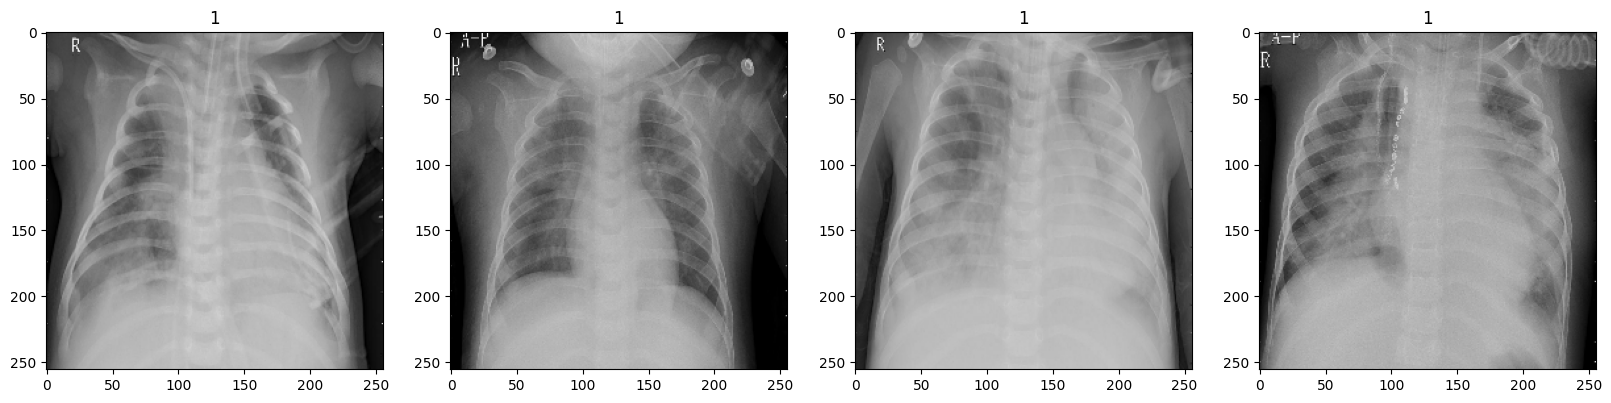

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


In [8]:
# normal is encoded as 0 and pneumonia is enconed to 1. 

### Scalling and splitting the data

In [9]:
data_map = data.map(lambda x,y: (x/255,y))
data_map.as_numpy_iterator()

In [10]:
train_size = int(len(data_map)*.7)
val_size = int(len(data_map)*.2)
test_size = int(len(data_map)*.1)
train_size

127

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Building the model

In [12]:
model = Sequential()

In [13]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [16]:
logdir = 'logs'

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
127/127 [==============================] - 43s 332ms/step - loss: 4.9630 - accuracy: 0.8155 - val_loss: 0.3192 - val_accuracy: 0.8819
Epoch 2/20
127/127 [==============================] - 44s 342ms/step - loss: 0.2224 - accuracy: 0.9131 - val_loss: 0.2571 - val_accuracy: 0.9158
Epoch 3/20
127/127 [==============================] - 47s 366ms/step - loss: 0.1838 - accuracy: 0.9309 - val_loss: 0.3013 - val_accuracy: 0.9201
Epoch 4/20
127/127 [==============================] - 49s 385ms/step - loss: 0.1217 - accuracy: 0.9532 - val_loss: 0.2383 - val_accuracy: 0.9253
Epoch 5/20
127/127 [==============================] - 49s 381ms/step - loss: 0.0810 - accuracy: 0.9715 - val_loss: 0.2485 - val_accuracy: 0.9384
Epoch 6/20
127/127 [==============================] - 50s 387ms/step - loss: 0.0480 - accuracy: 0.9825 - val_loss: 0.2361 - val_accuracy: 0.9470
Epoch 7/20
127/127 [==============================] - 50s 393ms/step - loss: 0.0744 - accuracy: 0.9727 - val_loss: 0.2504 - val_ac

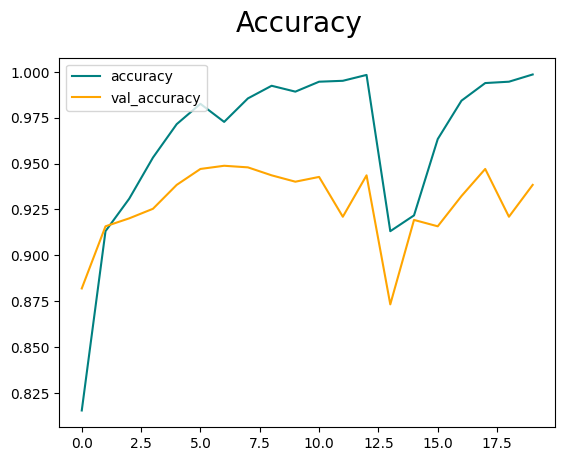

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

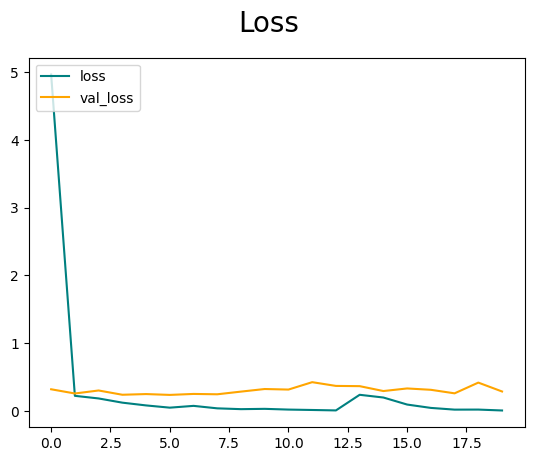

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluation of performance

In [20]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [21]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print("Precision:", f"{pre.result().numpy() * 100:.2f}%")
print("Recall:", f"{re.result().numpy() * 100:.2f}%")
print("Binary Accuracy:", f"{acc.result().numpy() * 100:.2f}%")


1/1 [==============================] - 0s 116ms/step
Precision: 96.35%
Recall: 94.51%
Binary Accuracy: 93.40%


### Testing on unseen data

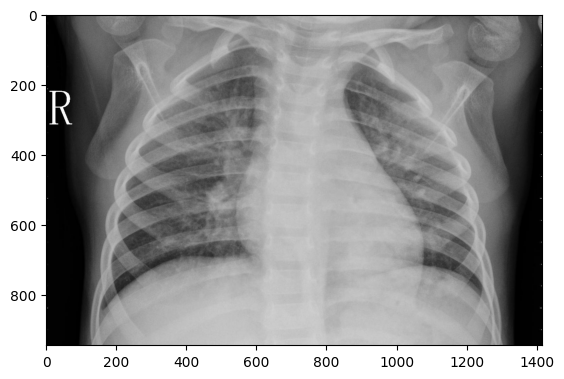

In [27]:
img = cv2.imread('extrad/PNEUMONIA/person1949_bacteria_4880.jpeg')
plt.imshow(img)
plt.show()

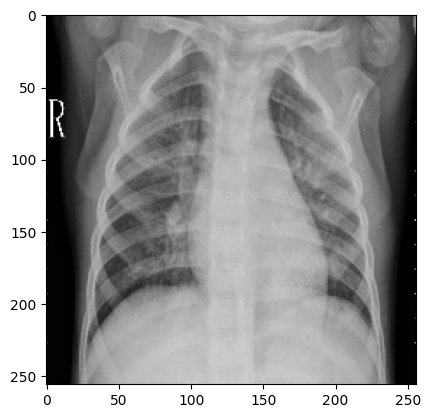

In [28]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [29]:
yhat = model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5: 
    print(f'Predicted class is Pneumonia')
else:
    print(f'Predicted class is Normal')

1/1 [==============================] - 0s 21ms/step
Predicted class is Pneumonia


### Save

In [31]:
model.save(os.path.join('models', 'pneumonia_or_not_classifier.keras'))

In [32]:
new_model = load_model(os.path.join('models', 'pneumonia_or_not_classifier.keras'))
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 46ms/step


array([[0.59965646]], dtype=float32)